# YOLO Example
### To start with, use built-in function in Gluoncv Library to illustrate how YOLO works

In [1]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

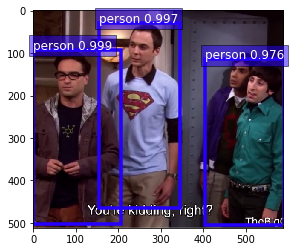

In [25]:
# use yolo mxnet package
num_frames = 250
for i in range(num_frames, num_frames+1):
    x, img = data.transforms.presets.yolo.load_test('tbbt2/' + 'frame' + str(i) + '.jpg', short=512)
    class_IDs, scores, bounding_boxs = net(x)
    ax = utils.viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
    
    # plot with predicted bounding boxes
    # be careful not to plot all frames at once: memory issues
    #plt.savefig('frames/' + 'frame' + str(i) + '.jpg') 

# Project begins here...

In [3]:
# load libraries
import os
import numpy as np
import cv2
#import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import misc
from PIL import Image

### Define functions to 
- extract frames,
- transform coordinates, 
- plot predicted bounding boxes
- save predictions to local
- convert predicted images to video

In [4]:
# extract frames from video
def extractFrames(pathIn, pathOut):
    """
    Input: video from pathIn
    Output: .jpg images to pathOut
    """
    if not os.path.exists(pathOut):
        os.mkdir(pathOut)
    
    # load video
    cap = cv2.VideoCapture(pathIn)
    count = 0
    
    while (cap.isOpened()):
        ret, frame = cap.read() # Capture frame-by-frame
        if ret == True:
            #print('Read %d frame: ' % count, ret) #verbose to keep track 
            cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
        else:
            break
    
    # release the capture when everything done
    cap.release()
    cv2.destroyAllWindows()
    
    return count

In [5]:
# transform the raw_input
def transform(raw_input):
    # create offset matrix - ask hans for further detail on transformation
    offset = np.reshape(np.tile(np.arange(7), reps = 7), (7, 7))
    # split confidence score
    confi = raw_input[:, :49]
    confidence = np.reshape(confi, (confi.shape[0], 7, 7, 1))
    # split position info
    position = raw_input[:, 49:49*5]
    position = np.reshape(position, (position.shape[0], 7, 7, 4))
    # split labels info
    labels = raw_input[:, 49*5:]
    labels = np.reshape(labels, (labels.shape[0], 7, 7, 2))
    # change position
    position[..., 2:] = position[..., 2:] ** 2
    position[..., 0] = (position[..., 0] + offset)/7
    position[..., 1] = (position[..., 1] + offset.transpose())/7
    return confidence, position, labels

In [6]:
# plot bounding box
def draw_bbox(image_file, confidence, position, labels, threshold, i):
    """
    Input:
        image_file - str, name of the image
        confidence - list, output of 'transform' function
        position - list, output of 'transform' function
        labels - list, output of 'transform' function
        threshold - floa, the confidence score used to select bounding boxes
        i - int, the index of frame
    Output:
        images with predicted bounding boxes 
    """
    bbox = []
    cell_position = []
    # add the grid [m, n] to the collection of bbox if the confidence score is good enough
    for m in range(7):
        for n in range(7):
            if confidence[i][m][n][0] > threshold:
                bbox.append(position[i][m][n])
    # resize input image
    im = np.array(Image.open(image_file), dtype=np.uint8)
    im = cv2.resize(im, (448,448))
    fig,ax = plt.subplots(1)
    ax.set_title('confidence threshold is %3f' % threshold)
    ax.imshow(im)
    # add every bbox to the image
    for k in range(len(bbox)):
        box = bbox[k]
        xmid = box[0] * 448
        ymid = box[1] * 448
        length = box[2] * 448
        width = box[3] * 448
        rect = patches.Rectangle((xmid - length/2, ymid - width/2), length, width, 
                                 linewidth=1,edgecolor='r',facecolor='none')
        # print(box[1:5])
        ax.add_patch(rect)
    plt.show()  

In [7]:
# save images with predicted bounding boxes to local file
def save_bbox(image_file, confidence, position, labels, threshold, i, pathout):
    """
    Input:
        image_file - str, name of the image
        confidence - list, output of 'transform' function
        position - list, output of 'transform' function
        labels - list, output of 'transform' function
        threshold - floa, the confidence score used to select bounding boxes
        i - int, the index of frame
        pathout - str, the directory to save frames
    Output:
        frame images with predicted bounding boxes in local file
    """
    bbox = []
    cell_position = []
    # add the grid [m, n] to the collection of bbox if the confidence score is good enough
    for m in range(7):
        for n in range(7):
            if confidence[i][m][n][0] > threshold:
                bbox.append(position[i][m][n])
    # resize input image
    im = np.array(Image.open(image_file), dtype=np.uint8)
    im = cv2.resize(im, (448,448))
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    # add every bbox to the image
    for k in range(len(bbox)):
        box = bbox[k]
        xmid = box[0] * 448
        ymid = box[1] * 448
        length = box[2] * 448
        width = box[3] * 448
        rect = patches.Rectangle((xmid - length/2, ymid - width/2), length, width, 
                                 linewidth=1,edgecolor='r',facecolor='none')
        # print(box[1:5])
        ax.add_patch(rect)
    plt.savefig(pathout + '/frame' + str(i) + '_output.jpg') 
    #print('frame %d done' % i)
    plt.close()

In [8]:
# convert image to video
def image_to_video(pathout, num_frames):
    """
    Input: str
        pathout - directory to save the output video
        num_frames - the index of last frame that you want to have in the video
    Output: 
        a mp4 video file
    """
    fps = 30
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    outfile = pathout + '_output_video.mp4'
    
    videoWriter = cv2.VideoWriter(outfile, fourcc, fps, (432,288)) 
    for i in range(num_frames-1): 
        img = cv2.imread(pathout + '/frame' + str(i) + '_output.jpg')
        videoWriter.write(img)
    
    print('video saved.')
    # release everything when work is done
    videoWriter.release()

# Working Pipeline

Only edit input file directories in this cell，please don't change other cells

In [9]:
"""
Three input files:

pathin - directory of input video
pathout - directory of output folder with extracted frames
bbox_pred - prediction of bounding boxes
"""
pathin = 'tbbt2.mov' 
pathout = 'tbbt2'
bbox_pred = 'tbbt2_2580train_100epoch.npy'

### You can uncomment the cell below to do a one-click yolo...

In [10]:
"""
print('Step 1: Extracting frames...')
num_frames = extractFrames(pathin, pathout)

print('Step 2: Transforming coordinates...')
y = np.load(bbox_pred)
confidence, position, labels = transform(y) 

print('Step 3: Saving images to local folder...')
for k in range(num_frames-1): #num_frames
    save_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.16, k, pathout)

print('Step 4: Converting images to video...')
image_to_video(pathout, num_frames)

print('Done! Now open the mp4 file to check out the result.')
"""

"\nprint('Step 1: Extracting frames...')\nnum_frames = extractFrames(pathin, pathout)\n\nprint('Step 2: Transforming coordinates...')\ny = np.load(bbox_pred)\nconfidence, position, labels = transform(y) \n\nprint('Step 3: Saving images to local folder...')\nfor k in range(num_frames-1): #num_frames\n    save_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.16, k, pathout)\n\nprint('Step 4: Converting images to video...')\nimage_to_video(pathout, num_frames)\n\nprint('Done! Now open the mp4 file to check out the result.')\n"

### Or you can check out each steps in details and adjust parameters threshold accordingly.

1. Extract frames from video

In [11]:
num_frames = extractFrames(pathin, pathout)

In [12]:
print('%d frames in total' % (num_frames))

2164 frames in total


2. Load predicted bounding boxes and transform raw input to required size

In [13]:
y = np.load(bbox_pred)
confidence, position, labels = transform(y) 
print('confidence score:')
print('max %.3f; min %.3f; median %.3f' % (np.max(confidence),np.min(confidence),np.median(confidence)))

confidence score:
max 0.581; min -0.076; median 0.017


3. print an example image with predicted bounding box

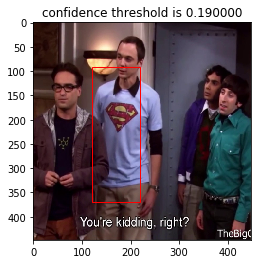

In [22]:
k = 250
draw_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.19, k)

4. save all images with predicted bounding box

In [15]:
print(np.percentile(confidence, 95))

0.13473755121231062


In [16]:
# if not using the whole video, choose the range of frames and update num_frames accordingly
# num_frames: index of the last frame
num_frames = 1000

for k in range(num_frames): 
    save_bbox(pathout + '/frame' + str(k) + '.jpg', confidence, position, labels, 0.17, k, pathout)

5. convert predicted images to video

In [17]:
image_to_video(pathout, num_frames) 

video saved.
